# Test problem from Caroe et al. (1999)

$$
\begin{align*}
\max_{x}      \quad & \frac{3}{2} x_1 + 4 x_2 + Q(x_1, x_2) \\
\mathrm{s.t.} \quad & 0 \leq x \leq 5 \\
                    & x \ \mathrm{integer}
\end{align*}
$$

where $Q(x_1,x_2)$:
$$
\begin{align*}
\max_{y}      \quad & 16 y_1 + 19 y_2 + 23 y_3 + 28 y_4 \\
\mathrm{s.t.} \quad & 2 y_1 + 3 y_2 + 4 y_3 + 5 y_4 \leq \zeta_1 - x_1 \\
                    & 6 y_1 + y_2 + 3 y_3 + 2 y_4 \leq \zeta_2 - x_2 \\
                    & y_i \in \{0,1\}
\end{align*}
$$
and $\zeta = (\zeta_1,\zeta_2)$ is uniformly distributed on
$$\Pi = \{(5,5), (5,6),\dots,(5,15),(6,5),\dots,(15,15)\}$$
giving 121 scenarios.

In [1]:
RELAX_LP = False

In [2]:
from __future__ import division
from cobra import Model
from dynamicme.optimize import Variable, Constraint
from six import iteritems
from dynamicme.decomposition import LagrangeMaster, LagrangeSubmodel

import numpy as np
import pandas as pd

In [3]:
zetas = [(i,j) for i in np.arange(5,16) for j in np.arange(5,16)]
print('Scenarios: %s'%len(zetas))

Scenarios: 121


In [4]:
cx = -np.array([3/2, 4])
fy = -np.array([16, 19, 23, 28])
xl = [0, 0]
xu = [5, 5]
A  = [[2,3,4,5],
      [6,1,3,2]]

sub_dict = {}
for k,zeta in enumerate(zetas):
    mdl = Model('sub')    
    ys  = [Variable('y_%d'%j, lower_bound=0, upper_bound=1, objective_coefficient=fy[j]) for j in range(len(fy))]
    xs  = [Variable('x_%d'%j, lower_bound=xl[j], upper_bound=xu[j], objective_coefficient=cx[j]) for j in range(len(cx))]
    for x in xs:
        x.variable_kind = 'integer'
    for y in ys:
        y.variable_kind = 'integer'
    mdl.add_reactions(xs+ys)
    for i,ai in enumerate(A):
        cons = Constraint('cons_%d'%i)
        cons._constraint_sense = 'L'
        cons._bound = zeta[i]
        xs[i].add_metabolites({cons:1})
        for j,aij in enumerate(ai):
            ys[j].add_metabolites({cons:aij})
    sub_id = 'scen_%d'%k
    sub = LagrangeSubmodel(mdl, sub_id, first_stage_vars=xs)
    sub._weight = 1./len(zetas)
    sub_dict[sub_id] = sub

In [5]:
master = LagrangeMaster(mdl, first_stage_vars=xs)
master._INF = 1e8
master.add_submodels(sub_dict)
master._z.LB = -master._INF
master._z.UB = master._INF
master.model.Params.Presolve = 0
master.model.update()
master.model.Params.NodefileStart = 3.
for sub in sub_dict.values():
    sub.model.Params.NodefileStart = 3.

In [6]:
master.gaptol = 1e-3
master.penaltytol = 1e-6 #1e-4
master.delta_mult = 0.5
master.delta_min = 0
master.bundle_mult = 0.1

feasible_methods = ['heuristic','enumerate']
alt_method = 'pool'
max_alt = 10


if RELAX_LP:
    master.verbosity=2
    master.max_iter = 100
    sol_master = master.solve_relaxed(feasible_methods=None)
    df_phase1 = pd.DataFrame(master.log_rows)

master.gaptol = 0.01
master.verbosity=1
master.max_iter = 100
master.max_max_alt = 100
sol_master = master.optimize(feasible_methods=feasible_methods, max_alt=max_alt, alt_method=alt_method,
                             early_heuristics=['average']) 
df_phase2 = pd.DataFrame(master.log_rows)

    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- ---------  -------- -----------------------------
               Best   Feasible        Sub       Best                                   total    master       sub
       0     -56.28     -56.28     -70.58     -70.58      14.3      25.4         0  0.305400  0.004752  0.170859
      10      -63.6     -56.28     -66.51     -65.24     1.649     2.593     0.372  2.664773  0.015175  0.105753
      14     -64.15     -56.28     -64.15     -64.15         0         0  1.48e-08  3.651072  0.062978  0.102177
Master ascent of 2.79304458672e-07 < 1e-06  below threshold. Stopping.
      14     -64.15     -62.29     -64.15     -64.15         0         0  1.48e-08  70.46833  0.062978  0.102177


In [7]:
master._z.X

-64.14765816926956

In [8]:
master.solve_lagrangian(master.uopt)

-64.14765842258932

In [9]:
df_phase2

,LB,bestLB,bestUB,delta,feasUB,gap,iter,relgap,res_u,t_master,t_sub,t_total
0,-70.578512,-70.578512,-56.280992,1.000000,-56.280992,14.297521,0,25.403818,0.000000e+00,0.004753,0.170860,0.212886
1,-70.519637,-70.519637,-70.519636,0.500000,-56.280992,0.000000,1,0.000000,2.943788e-02,0.002646,0.095757,0.445286
2,-70.401885,-70.401885,-70.401886,0.250000,-56.280992,0.000000,2,0.000000,5.887576e-02,0.003003,0.104038,0.689271
3,-70.166382,-70.166382,-70.166382,0.125000,-56.280992,0.000000,3,0.000000,1.177515e-01,0.003498,0.098122,0.930347
4,-69.707534,-69.707534,-69.695376,0.062500,-56.280992,0.012158,4,0.017444,2.355030e-01,0.005020,0.101710,1.174291
5,-68.927310,-68.927310,-68.777047,0.031250,-56.280992,0.150264,5,0.218479,4.640412e-01,0.005377,0.101307,1.420071
6,-67.905667,-67.905667,-67.502049,0.015625,-56.280992,0.403618,6,0.597935,6.995459e-01,0.007133,0.104095,1.668357
7,-66.710641,-66.710641,-65.643798,0.007812,-56.280992,1.066844,7,1.625201,1.037108e+00,0.008422,0.108981,1.921846
8,-65.855593,-65.855593,-64.167812,0.003906,-56.280992,1.687781,8,2.630261,1.129446e+00,0.010523,0.105285,2.173132
9,-65.244299,-65.244299,-63.385585,0.001953,-56.280992,1.858713,9,2.932391,7.198929e-01,0.011412,0.107905,2.419008


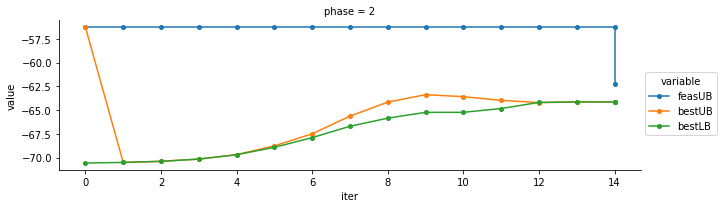

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

xcol = 'iter'
if RELAX_LP:
    df_phase1.loc[:,'phase'] = 1
    df_phase1.loc[:,'feasUB'] = np.nan
    df_phase1.loc[ df_phase1.bestUB>1e6,'bestUB'] = np.nan

df_phase2.loc[:,'phase'] = 2
df_phase2.loc[ df_phase2.feasUB>1e6,'feasUB'] = np.nan
if RELAX_LP:
    dsplot = pd.concat([df_phase1, df_phase2])
else:
    dsplot = df_phase2
dsplot = dsplot[[xcol,'feasUB','bestUB','bestLB','phase']]
dsplot = dsplot.melt(id_vars=[xcol,'phase'])

g = sns.FacetGrid(dsplot, hue='variable', size=3, aspect=3, row='phase', sharey=False)
g.map(plt.plot, xcol,'value', marker='o', markersize=4)
g.add_legend()

In [11]:
objfun = master.model.getObjective()

In [12]:
for i in [10, 100]: #, 1000, 10000]:
    cons = master.model.getConstrs()[i]
    print("%s %s %s" % (master.model.getRow(cons), cons.Sense, cons.RHS))

<gurobi.LinExpr: tk_scen_19 + u_80 + 5.0 u_81> < -56.5
<gurobi.LinExpr: tk_scen_24 + 3.0 u_981> < -54.0


for i in range(len(master.model.getConstrs())):
    cons = master.model.getConstrs()[i]
    print("%s %s %s" % (master.model.getRow(cons), cons.Sense, cons.RHS))

In [13]:
master.model.ObjVal

-64.12397266977834